In [4]:
import csv
import numpy as np
import pandas as pd
from math import factorial

import datetime
from datetime import date

import time

import scipy
import os, os.path
from os import listdir
from os.path import isfile, join

import re
# from pprint import pprint
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sb

import sys


# search path for modules
# look @ https://stackoverflow.com/questions/67631/how-to-import-a-module-given-the-full-path
sys.path.append('/Users/hn/Documents/00_GitHub/Ag/NASA/Python_codes/')
import NASA_core as nc
import NASA_plot_core as npc

In [5]:
data_dir = "/Users/hn/Documents/01_research_data/NASA/VI_TS/data_for_train_individual_counties/"
L7 = pd.read_csv(data_dir + "L7_T1C2L2_Scaled_Monterey2014_2013-01-01_2015-12-31.csv")
L8 = pd.read_csv(data_dir + "L8_T1C2L2_Scaled_Monterey2014_2013-01-01_2015-12-31.csv")

In [6]:
# data_dir = "/Users/hn/Documents/01_research_data/NASA/VI_TS/sixth_investig_intersected/"

# L5 = pd.read_csv(data_dir + "L5_T1C2L2_Scaled_intGrant_2008-01-01_2012-05-05.csv")
# L7 = pd.read_csv(data_dir + "L7_T1C2L2_Scaled_intGrant_2008-01-01_2021-09-23.csv")
# L8 = pd.read_csv(data_dir + "L8_T1C2L2_Scaled_intGrant_2008-01-01_2021-10-14.csv")

In [7]:
indeks = "EVI"

if indeks == "NDVI":
    NoVI = "EVI"
else:
    NoVI = "NDVI"
    
IDcolName = "ID"

In [8]:
L7.drop([NoVI], axis=1, inplace=True)
L7 = L7[L7[indeks].notna()]

L8.drop([NoVI], axis=1, inplace=True)
L8 = L8[L8[indeks].notna()]
L8.head(2)

,ID,EVI,system_start_time
9,13235,0.397043,1.363977e+12
27,8868,0.202969,1.363977e+12


In [9]:
IDs = np.sort(L7[IDcolName].unique())
Monterey = pd.concat([L7, L8])

In [10]:
del(L7, L8)
Monterey = nc.add_human_start_time_by_system_start_time(Monterey)
Monterey.head(2)

,ID,EVI,system_start_time,human_system_start_time
0,12999,0.127193,1.357152e+09,2013-01-02
2,13049,0.157159,1.357152e+09,2013-01-02


In [11]:
curr_ID = IDs[0]

In [12]:
a_field = Monterey.loc[Monterey.ID == curr_ID, ].copy()
a_field.sort_values(by='human_system_start_time', axis=0, ascending=True, inplace=True)
a_field.reset_index(drop=True, inplace=True)

### pre-processing

In [10]:
a_field = nc.initial_clean(df = a_field, column_to_be_cleaned = indeks)
a_field.drop(["system_start_time"], axis=1, inplace=True)

In [11]:
print (a_field[indeks].min())
print (a_field[indeks].max())

0.0772170686853982
0.7776603633111959


# Remove/Interpolate Outliers

In [12]:
noOutlier = nc.interpolate_outliers_EVI_NDVI(outlier_input=a_field, given_col=indeks)
print (noOutlier.shape)
noOutlier.head(2)

(195, 3)


,ID,EVI,human_system_start_time
0,1,0.089259,2013-01-02
1,1,0.134279,2013-01-11


In [13]:
print (noOutlier[indeks].min())
print (noOutlier[indeks].max())
noOutlier.equals(a_field)

0.0772170686853982
0.7776603633111959


True

# Correct Big Jumps

In [14]:
NoJump_v1 = nc.correct_big_jumps_1DaySeries(dataTMS_jumpie = noOutlier, give_col = indeks, maxjump_perDay = 0.018)

In [15]:
NoJump_v2 = nc.correct_big_jumps_1DaySeries_JFD(dataTMS_jumpie = noOutlier, 
                                            give_col = indeks, 
                                            maxjump_perDay = 0.018)

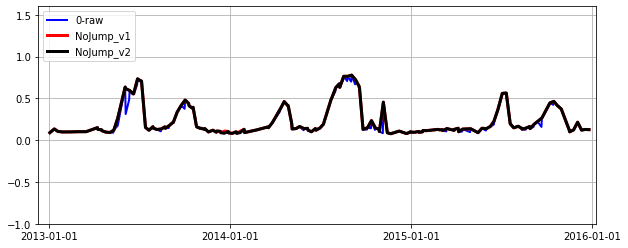

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4),
                        sharex='col', sharey='row',
                        # sharex=True, sharey=True,
                        gridspec_kw={'hspace': 0.2, 'wspace': .05});
ax.grid(True);
ax.plot(a_field['human_system_start_time'], 
        a_field['EVI'], 
        '-', linewidth=2, color='b', label = "0-raw")

ax.plot(NoJump_v1['human_system_start_time'], 
        NoJump_v1['EVI'], 
        '-', linewidth=3, color='r', label = "NoJump_v1")

ax.plot(NoJump_v2['human_system_start_time'], 
        NoJump_v2['EVI'], 
        '-', linewidth=3, color='k', label = "NoJump_v2")

xx = datetime.date(2019, 2, 28)
# plt.axvline(x=xx, color="red", label=xx)

ax.xaxis.set_major_locator(mdates.YearLocator(1)) # every year.
ax.legend(loc="upper left");
ax.set_ylim(-1, 1.6)
ax.set_xlim([datetime.date(2012, 12, 10), datetime.date(2016, 1, 10)])
# ax.set_xlim([datetime.date(2019, 1, 10), datetime.date(2020, 1, 1)])

plot_dir = "/Users/hn/Desktop/"
# file_name = plot_dir + # "i17302.pdf"
# plt.savefig(fname = file_name, dpi=100, bbox_inches='tight', transparent=False)

# Regularize

In [17]:
regular_window_size = 10
regular = nc.regularize_a_field(a_df = NoJump_v2, \
                                V_idks = indeks, \
                                interval_size = regular_window_size,\
                                start_year=2013, \
                                end_year=2015)

In [18]:
regular = nc.fill_theGap_linearLine(a_regularized_TS=regular, V_idx=indeks)

# SG

In [19]:
SG = scipy.signal.savgol_filter(regular[indeks].values, window_length=7, polyorder=3)
SG[SG > 1 ] = 1 # SG might violate the boundaries. clip them:
SG[SG < -1 ] = -1

In [20]:
SG_df = regular.copy()
SG_df[indeks] = SG
SG_df.head(2)

,ID,human_system_start_time,EVI
0,1,2013-01-02,0.133128
1,1,2013-01-12,0.108012


(15684.0, 16810.0)

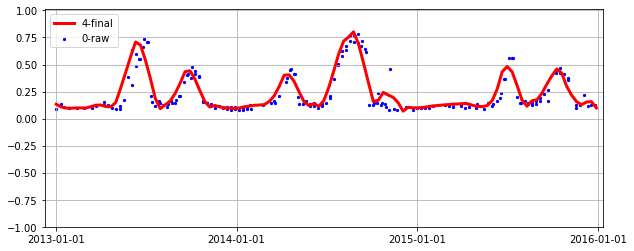

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4),
                       sharex='col', sharey='row',
                       gridspec_kw={'hspace': 0.2, 'wspace': .05});
ax.grid(True);
# ax.plot(a_field['human_system_start_time'], 
#         a_field['EVI'], 
#         '-', linewidth=2, color='b', label = "0-raw")

ax.scatter(a_field['human_system_start_time'], 
           a_field['EVI'], 
           s=5, color='b', label = "0-raw")

ax.plot(regular['human_system_start_time'], 
        SG, 
        '-', linewidth=3, color='r', label = "4-final")

xx = datetime.date(2019, 2, 28)

ax.xaxis.set_major_locator(mdates.YearLocator(1)) # every year.
ax.legend(loc="upper left");
ax.set_ylim(-1, 1.01)
ax.set_xlim([datetime.date(2012, 12, 10), datetime.date(2016, 1, 10)])

# SOS Detection

In [22]:
regular[indeks] = SG

regular = regular.reindex(columns= a_field.columns)
regular["ID"] = regular["ID"].astype(str)
a_field["ID"] = a_field["ID"].astype(str)

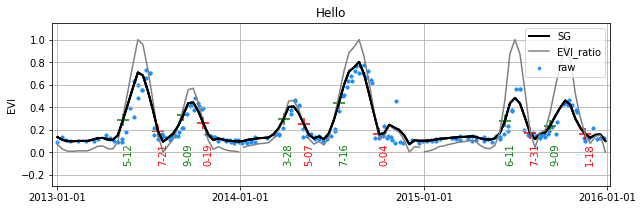

In [65]:
fig, ax = plt.subplots(1, 1, figsize=(10, 3),
                            sharex='col', sharey='row',
                            gridspec_kw={'hspace': 0.1, 'wspace': .1});

ax.grid(True);

npc.SG_clean_SOS_orchardinPlot(raw_dt = a_field,
                               SG_dt = regular,
                               idx = indeks,
                               ax = ax,
                               onset_cut = 0.3, 
                               offset_cut = 0.3);

ax.set_title("Hello");

# Find SOS and EOS

In [35]:
check =  all(item in list([1, 2, 3, 4, 5]) for item in list([1, 2, 3, 5]))
check

True

In [32]:
item in list([1, 2, 3]) for item in list([1, 2, 3, 4, 5])

SyntaxError: invalid syntax (<ipython-input-32-b56fc5e83f59>, line 1)